# Figure 1: Adhesome in GM12878 HiC

In [1]:
# Import standard libraries
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from brokenaxes import brokenaxes
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
sys.path.insert(0,'..')
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '../correlation_clustering.py'>

In [2]:
# Specify all directories
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_GM12878/final_BP250000_intraKR_interGWKR/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_GM12878/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_GM12878/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Relevant information
cell_type = 'GM12878'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

### Load auxiliary data

In [4]:
# Load dictionaries
gene2locus = pickle.load(open(saving_dir+'gene2locus.pkl','rb'))
locus2gene = pickle.load(open(saving_dir+'locus2gene.pkl','rb'))
gene2chrom = pickle.load(open(saving_dir+'gene2chrom.pkl','rb'))

In [5]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)

### Load gene data

In [34]:
# Active genes in GM12878
all_active_genes = pickle.load(open(saving_dir+'active_genes_GM12878.pkl','rb'))

In [6]:
# Adhesome genes
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl','rb'))
all_adhesome_genes = adhesome_chr_loci['gene'].unique()
all_adhesome_loci = adhesome_chr_loci['locus_id'].unique()

In [7]:
# TCR genes
tcr_chr_loci = pickle.load(open(saving_dir+'tcr_chr_loci.pkl','rb'))
all_tcr_genes = tcr_chr_loci['gene'].unique()
all_tcr_loci = tcr_chr_loci['locus_id'].unique()

In [8]:
# BCR
bcr_chr_loci = pickle.load(open(saving_dir+'bcr_chr_loci.pkl','rb'))
all_bcr_genes = bcr_chr_loci['gene'].unique()
all_bcr_loci = bcr_chr_loci['locus_id'].unique()

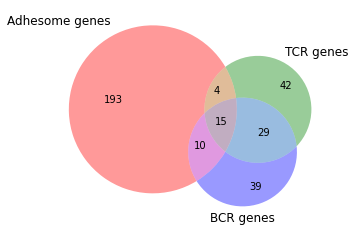

In [9]:
# See overlp between gene lists
plt.figure()
venn3(subsets = (set(all_adhesome_genes), set(all_tcr_genes), set(all_bcr_genes)), 
      set_labels = ('Adhesome genes', 'TCR genes', 'BCR genes'))
plt.show()

In [31]:
# Identify genes in the intersection
specific_adhesome_genes = np.array(list(set(all_adhesome_genes)-set(all_tcr_genes)-set(all_bcr_genes)))
specific_tcr_genes = np.array(list(set(all_tcr_genes)-set(all_adhesome_genes)-set(all_bcr_genes)))
specific_bcr_genes = np.array(list(set(all_bcr_genes)-set(all_adhesome_genes)-set(all_tcr_genes)))
common_genes = np.array(list(set.intersection(*[set(all_adhesome_genes), set(all_tcr_genes), set(all_bcr_genes)])))
common_genes = np.array(list(set.union(*[set(all_adhesome_genes), set(all_tcr_genes), set(all_bcr_genes)])-
                             set(specific_adhesome_genes)-set(specific_tcr_genes)-set(specific_bcr_genes)))

In [10]:
# Selected loci
loci_list = np.unique(np.concatenate([all_adhesome_loci, all_tcr_loci, all_bcr_loci]))
print(f'Number of selected loci = {len(loci_list)}')

Number of selected loci = 431


In [11]:
# Buld map from selected loci to corresponding genes
selected_locus2gene = {}
for loc in loci_list:
    adhesome_g = adhesome_chr_loci[adhesome_chr_loci['locus_id']==loc]['gene'].unique()
    tcr_g = tcr_chr_loci[tcr_chr_loci['locus_id']==loc]['gene'].unique()
    bcr_g = bcr_chr_loci[bcr_chr_loci['locus_id']==loc]['gene'].unique()
    selected_locus2gene[loc] = np.unique(np.concatenate([adhesome_g, tcr_g, bcr_g]))

In [76]:
# Compute corresponding Hi-C matrix
contacts_df = pd.DataFrame(0, index=loci_list, columns=loci_list)
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_df.loc[locus1_id, locus2_id] = hic_chpair_df.loc[locus1,locus2]
# Symmetrize data frame
contacts_df = contacts_df+contacts_df.T

100%|██████████| 231/231 [00:19<00:00, 11.72it/s]


In [77]:
# Create interX edge list
interX_edge_list = cc.create_interX_edgelist(contacts_df, loci_list, selected_locus2gene, gene2chrom)
# Create intraX edge list
intraX_edge_list = cc.create_intraX_edgelist(loci_list, selected_locus2gene, df_loc, resol, dir_processed_hic)

100%|██████████| 22/22 [00:18<00:00,  1.20it/s]


In [78]:
# Combine edge lists
inter_selected = interX_edge_list[interX_edge_list['scaled_hic']>0]
intra_selected = intraX_edge_list[intraX_edge_list['scaled_hic']>0][['source','target',
                                                                       'hic','scaled_hic']]
all_selected = pd.concat([inter_selected, intra_selected], axis=0)

In [81]:
# Create network and obtain adjacency matrix
G = nx.from_pandas_edgelist(all_selected, edge_attr='scaled_hic')
adj = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic').todense())
adj = pd.DataFrame(adj, index=sorted(G.nodes), columns=sorted(G.nodes))
pickle.dump(adj, open(saving_dir+'combined_adjmat_GM12878.pkl','wb'))

In [82]:
adj

,ABI1,ABI2,ABI3,ABL1,ACTB,ACTN1,ADAM12,AGAP2,AKT1,ANKRD28,...,TSPAN1,TUBA1B,VASP,VAV2,VAV3,VCL,VIM,ZAP70,ZFYVE21,ZYX
ABI1,0.969583,0.402001,0.514918,0.450993,0.454534,0.439475,0.292948,0.471980,0.454097,0.413139,...,0.467401,0.531701,0.518766,0.384216,0.460267,0.434494,0.502225,0.469354,0.490680,0.408610
ABI2,0.402001,0.914373,0.455518,0.444483,0.462178,0.456527,0.371088,0.420218,0.398494,0.447499,...,0.468967,0.438963,0.446183,0.368782,0.358754,0.450510,0.345468,0.365079,0.473073,0.448579
ABI3,0.514918,0.455518,0.982344,0.596927,0.557425,0.520271,0.353455,0.527971,0.607519,0.509819,...,0.602216,0.613961,0.638136,0.581132,0.353308,0.557492,0.417935,0.550260,0.618571,0.289252
ABL1,0.450993,0.444483,0.596927,0.932137,0.507824,0.540177,0.323759,0.431735,0.629646,0.467983,...,0.540870,0.572527,0.553989,0.592565,0.378417,0.527370,0.351420,0.512491,0.624276,0.378806
ACTB,0.454534,0.462178,0.557425,0.507824,0.971908,0.495200,0.350694,0.552426,0.547202,0.494686,...,0.576474,0.567787,0.600980,0.525471,0.370600,0.528792,0.411004,0.460836,0.555573,0.324467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VCL,0.434494,0.450510,0.557492,0.527370,0.528792,0.505589,0.322296,0.493861,0.502836,0.488517,...,0.537768,0.591964,0.558065,0.502053,0.321530,0.968280,0.326644,0.461812,0.566091,0.322444
VIM,0.502225,0.345468,0.417935,0.351420,0.411004,0.443448,0.343200,0.347793,0.332985,0.356693,...,0.427719,0.446942,0.388807,0.308043,0.405060,0.326644,0.944163,0.329741,0.373976,0.388705
ZAP70,0.469354,0.365079,0.550260,0.512491,0.460836,0.497532,0.311254,0.434534,0.503410,0.383667,...,0.480624,0.512739,0.492795,0.459275,0.374581,0.461812,0.329741,0.950359,0.543010,0.344974
ZFYVE21,0.490680,0.473073,0.618571,0.624276,0.555573,0.445624,0.358426,0.491173,0.726768,0.460730,...,0.546973,0.595181,0.652918,0.672695,0.366166,0.566091,0.373976,0.543010,0.979309,0.446373


### Analyze maps: all genes

In [12]:
# Load adjacency matrices
combined_adjmat_GM12878 = pickle.load(open(saving_dir+'combined_adjmat_GM12878.pkl','rb'))

In [35]:
# Adhesome contacts
adhesome_genes_in_index = np.array(list(set.intersection(*[set(all_adhesome_genes),
                                                           set(combined_adjmat_GM12878.index.values),
                                                           set(all_active_genes)] )))
adhesome_flat = combined_adjmat_GM12878.loc[adhesome_genes_in_index, adhesome_genes_in_index].values
adhesome_flat = adhesome_flat[np.triu_indices(len(adhesome_genes_in_index), 1)]
# TCR contacts
tcr_genes_in_index = np.array(list(set.intersection(*[set(all_tcr_genes),
                                                      set(combined_adjmat_GM12878.index.values),
                                                           set(all_active_genes)])))
tcr_flat = combined_adjmat_GM12878.loc[tcr_genes_in_index, tcr_genes_in_index].values
tcr_flat = tcr_flat[np.triu_indices(len(tcr_genes_in_index), 1)]
# BCR contacts
bcr_genes_in_index = np.array(list(set.intersection(*[set(all_bcr_genes),
                                                      set(combined_adjmat_GM12878.index.values),
                                                           set(all_active_genes)])))
bcr_flat = combined_adjmat_GM12878.loc[bcr_genes_in_index, bcr_genes_in_index].values
bcr_flat = bcr_flat[np.triu_indices(len(bcr_genes_in_index), 1)]

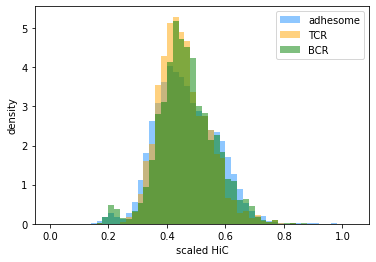

In [36]:
# Plot histograms
plt.figure()
plt.hist(adhesome_flat, bins=np.arange(0,1.05, .02), color='dodgerblue', alpha=0.5, density=True,
         label='adhesome')
plt.hist(tcr_flat, bins=np.arange(0,1.05, .02), color='orange', alpha=0.5, density=True,
         label='TCR')
plt.hist(bcr_flat, bins=np.arange(0,1.05, .02), color='green', alpha=0.5, density=True,
         label='BCR')
plt.legend(loc='upper right')
plt.xlabel('scaled HiC')
plt.ylabel('density')
plt.show()

### Analyze maps: specific genes

In [37]:
# Adhesome contacts
adhesome_genes_in_index = np.array(list(set.intersection(*[set(specific_adhesome_genes),
                                                           set(combined_adjmat_GM12878.index.values),
                                                           set(all_active_genes)] )))
adhesome_flat = combined_adjmat_GM12878.loc[adhesome_genes_in_index, adhesome_genes_in_index].values
adhesome_flat = adhesome_flat[np.triu_indices(len(adhesome_genes_in_index), 1)]
# TCR contacts
tcr_genes_in_index = np.array(list(set.intersection(*[set(specific_tcr_genes),
                                                      set(combined_adjmat_GM12878.index.values),
                                                           set(all_active_genes)])))
tcr_flat = combined_adjmat_GM12878.loc[tcr_genes_in_index, tcr_genes_in_index].values
tcr_flat = tcr_flat[np.triu_indices(len(tcr_genes_in_index), 1)]
# BCR contacts
bcr_genes_in_index = np.array(list(set.intersection(*[set(specific_bcr_genes),
                                                      set(combined_adjmat_GM12878.index.values),
                                                           set(all_active_genes)])))
bcr_flat = combined_adjmat_GM12878.loc[bcr_genes_in_index, bcr_genes_in_index].values
bcr_flat = bcr_flat[np.triu_indices(len(bcr_genes_in_index), 1)]

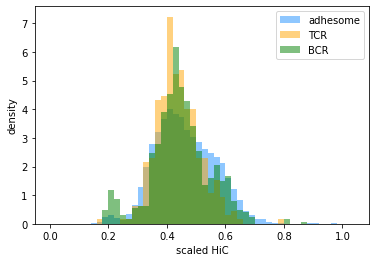

In [38]:
# Plot histograms
plt.figure()
plt.hist(adhesome_flat, bins=np.arange(0,1.05, .02), color='dodgerblue', alpha=0.5, density=True,
         label='adhesome')
plt.hist(tcr_flat, bins=np.arange(0,1.05, .02), color='orange', alpha=0.5, density=True,
         label='TCR')
plt.hist(bcr_flat, bins=np.arange(0,1.05, .02), color='green', alpha=0.5, density=True,
         label='BCR')
plt.legend(loc='upper right')
plt.xlabel('scaled HiC')
plt.ylabel('density')
plt.show()

### Analyze maps: common genes

In [39]:
# In index
common_genes_in_index = np.array(list(set.intersection(*[set(common_genes),
                                                           set(combined_adjmat_GM12878.index.values),
                                                           set(all_active_genes)] )))
# Adhesome contacts
adhesome_genes_in_index = np.array(list(set.intersection(*[set(specific_adhesome_genes),
                                                           set(combined_adjmat_GM12878.index.values),
                                                           set(all_active_genes)] )))
adhesome_flat = combined_adjmat_GM12878.loc[common_genes_in_index, adhesome_genes_in_index].values
adhesome_flat = adhesome_flat.flatten()
# TCR contacts
tcr_genes_in_index = np.array(list(set.intersection(*[set(specific_tcr_genes),
                                                      set(combined_adjmat_GM12878.index.values),
                                                           set(all_active_genes)])))
tcr_flat = combined_adjmat_GM12878.loc[common_genes_in_index, tcr_genes_in_index].values
tcr_flat = tcr_flat.flatten()
# BCR contacts
bcr_genes_in_index = np.array(list(set.intersection(*[set(specific_bcr_genes),
                                                      set(combined_adjmat_GM12878.index.values),
                                                           set(all_active_genes)])))
bcr_flat = combined_adjmat_GM12878.loc[common_genes_in_index, bcr_genes_in_index].values
bcr_flat = bcr_flat.flatten()

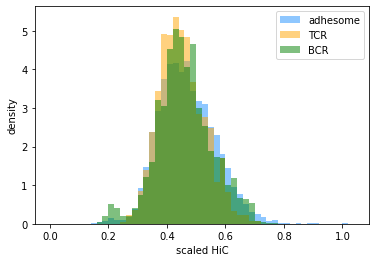

In [40]:
# Plot histograms
plt.figure()
plt.hist(adhesome_flat, bins=np.arange(0,1.05, .02), color='dodgerblue', alpha=0.5, density=True,
         label='adhesome')
plt.hist(tcr_flat, bins=np.arange(0,1.05, .02), color='orange', alpha=0.5, density=True,
         label='TCR')
plt.hist(bcr_flat, bins=np.arange(0,1.05, .02), color='green', alpha=0.5, density=True,
         label='BCR')
plt.legend(loc='upper right')
plt.xlabel('scaled HiC')
plt.ylabel('density')
plt.show()

In [30]:
common_genes

array([], dtype=float64)